#

# GDP与人口对奖牌数影响的相关性分析

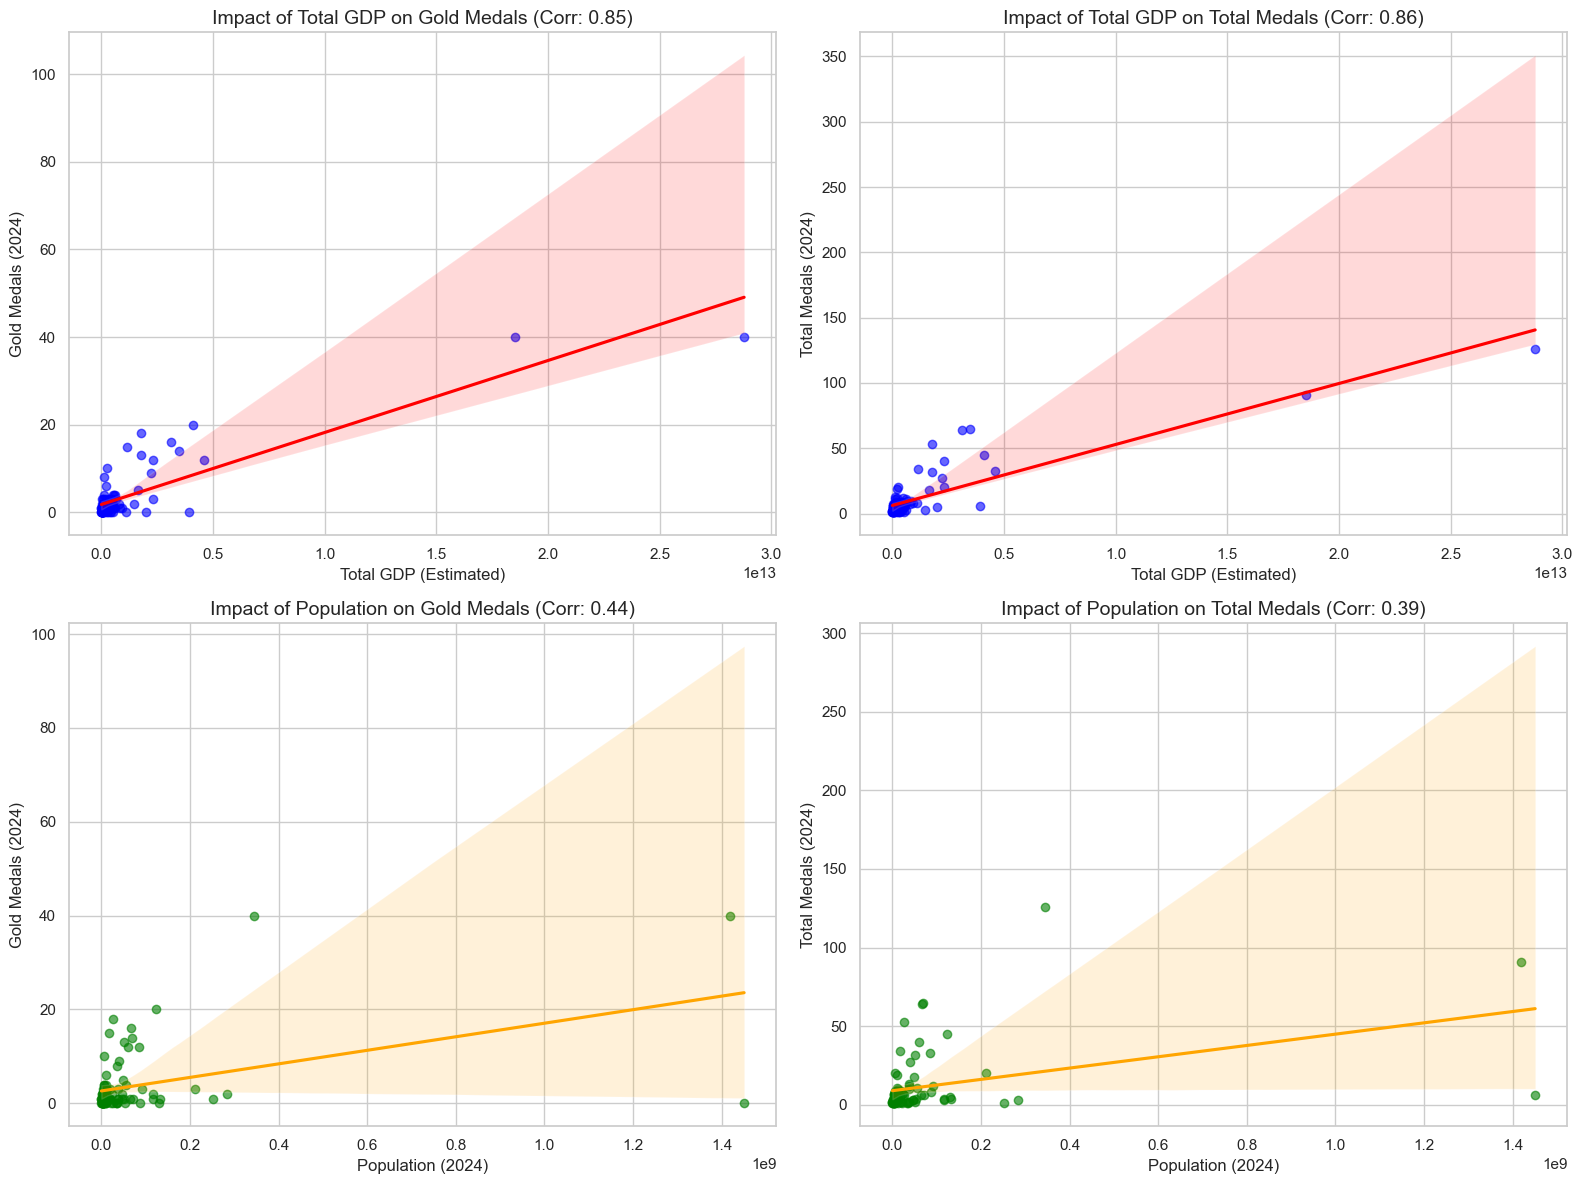

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read data
# Ensure the csv file is in the current directory or provide the correct path
df = pd.read_csv('medals_population_gdp_2024_2004_processed.csv')

# 2. Data Processing
# Calculate Total Medals 2024
df['Total Medals 2024'] = df['Gold 2024'] + df['Silver 2024'] + df['Bronze 2024']

# Calculate Total GDP Estimate
# 'GDP 2024' is likely per capita, so multiply by population to get total economic size
df['Total GDP Estimate'] = df['Population 2024'] * df['GDP 2024']

# 3. Plotting Setup
sns.set(style="whitegrid")
# Default font works well for English
plt.rcParams['font.family'] = 'sans-serif' 

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Analysis A: Total GDP vs Medals ---

# Plot 1: Total GDP vs Gold Medals
sns.regplot(x='Total GDP Estimate', y='Gold 2024', data=df, ax=axes[0, 0], 
            scatter_kws={'alpha':0.6, 'color': 'blue'}, line_kws={'color':'red'})
corr_gdp_gold = df['Total GDP Estimate'].corr(df['Gold 2024'])
axes[0, 0].set_title(f'Impact of Total GDP on Gold Medals (Corr: {corr_gdp_gold:.2f})', fontsize=14)
axes[0, 0].set_xlabel('Total GDP (Estimated)', fontsize=12)
axes[0, 0].set_ylabel('Gold Medals (2024)', fontsize=12)

# Plot 2: Total GDP vs Total Medals
sns.regplot(x='Total GDP Estimate', y='Total Medals 2024', data=df, ax=axes[0, 1], 
            scatter_kws={'alpha':0.6, 'color': 'blue'}, line_kws={'color':'red'})
corr_gdp_total = df['Total GDP Estimate'].corr(df['Total Medals 2024'])
axes[0, 1].set_title(f'Impact of Total GDP on Total Medals (Corr: {corr_gdp_total:.2f})', fontsize=14)
axes[0, 1].set_xlabel('Total GDP (Estimated)', fontsize=12)
axes[0, 1].set_ylabel('Total Medals (2024)', fontsize=12)


# --- Analysis B: Population vs Medals ---

# Plot 3: Population vs Gold Medals
sns.regplot(x='Population 2024', y='Gold 2024', data=df, ax=axes[1, 0], 
            scatter_kws={'alpha':0.6, 'color': 'green'}, line_kws={'color':'orange'})
corr_pop_gold = df['Population 2024'].corr(df['Gold 2024'])
axes[1, 0].set_title(f'Impact of Population on Gold Medals (Corr: {corr_pop_gold:.2f})', fontsize=14)
axes[1, 0].set_xlabel('Population (2024)', fontsize=12)
axes[1, 0].set_ylabel('Gold Medals (2024)', fontsize=12)

# Plot 4: Population vs Total Medals
sns.regplot(x='Population 2024', y='Total Medals 2024', data=df, ax=axes[1, 1], 
            scatter_kws={'alpha':0.6, 'color': 'green'}, line_kws={'color':'orange'})
corr_pop_total = df['Population 2024'].corr(df['Total Medals 2024'])
axes[1, 1].set_title(f'Impact of Population on Total Medals (Corr: {corr_pop_total:.2f})', fontsize=14)
axes[1, 1].set_xlabel('Population (2024)', fontsize=12)
axes[1, 1].set_ylabel('Total Medals (2024)', fontsize=12)

# Adjust layout and show
plt.tight_layout()
plt.show()

# 国际奥委会决策建议 (基于 UCB 算法)

=== 国际奥委会决策建议 (基于 UCB 算法) ===
      country  Has_Hosted  Mu_Capability  Sigma  Score_UCB
United States           1       0.971121   0.05   1.021121
  New Zealand           0       0.639075   0.25   0.889075
        China           1       0.832384   0.05   0.882384
Great Britain           1       0.831767   0.05   0.881767
       France           1       0.825039   0.05   0.875039
    Australia           1       0.809416   0.05   0.859416
      Hungary           0       0.594582   0.25   0.844582
  Switzerland           0       0.565305   0.25   0.815305
        Japan           1       0.761323   0.05   0.811323
       Norway           0       0.554456   0.25   0.804456


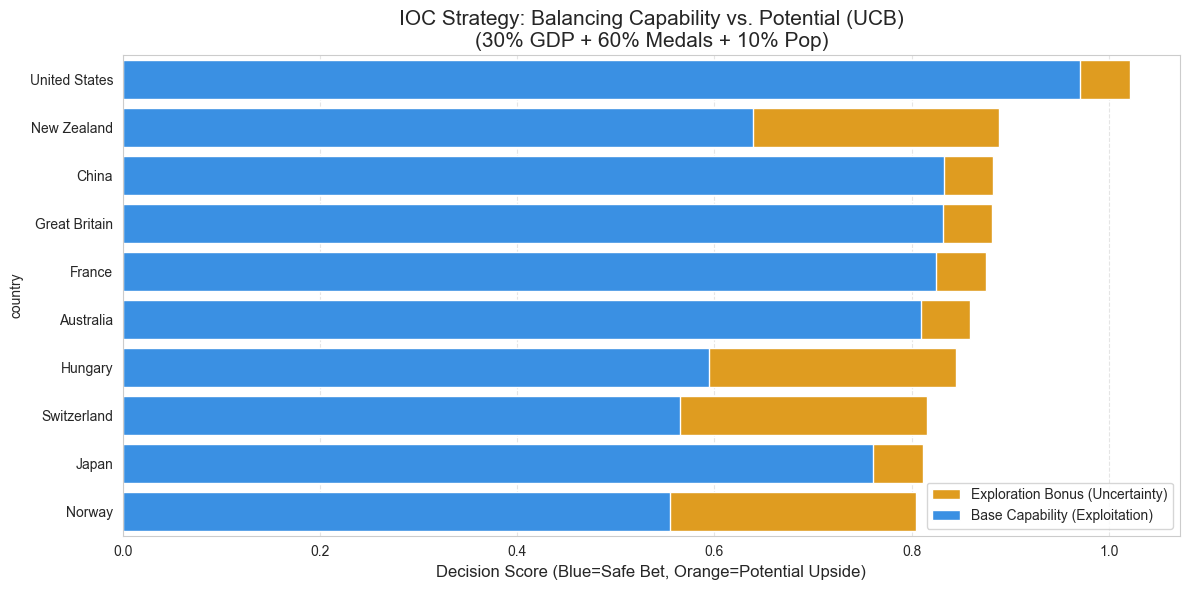

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. 数据准备与特征工程
# ==========================================
# 加载数据
df_gdp = pd.read_csv('medals_population_gdp_2024_2004_processed.csv')
df_hosts = pd.read_csv('summerOly_hosts.csv')

# 计算 2024 总奖牌数
df_gdp['Total_Medals_2024'] = df_gdp['Gold 2024'] + df_gdp['Silver 2024'] + df_gdp['Bronze 2024']

# --- 关键步骤：定义谁是"已知宿主"(Has Hosted) ---
# 需要处理国家名称的不一致 (如 "United States" vs "St. Louis, United States")
host_mapping = {
    'United States': 'United States', 'Great Britain': 'United Kingdom',
    'United Kingdom': 'United Kingdom', 'China': 'China', 'France': 'France',
    'Japan': 'Japan', 'Germany': 'Germany', 'Australia': 'Australia',
    'Greece': 'Greece', 'Sweden': 'Sweden', 'Belgium': 'Belgium',
    'Netherlands': 'Netherlands', 'Finland': 'Finland', 'Italy': 'Italy',
    'Mexico': 'Mexico', 'Canada': 'Canada', 'Russia': 'Russia',
    'South Korea': 'South Korea', 'Korea': 'South Korea', 'Spain': 'Spain',
    'Brazil': 'Brazil'
}

# 提取主办国名单
def clean_host_country(s):
    if not isinstance(s, str): return ''
    for k, v in host_mapping.items():
        if k in s or v in s: return v
    return s.split(',')[-1].strip()

df_hosts['Clean_Host'] = df_hosts['Host'].apply(clean_host_country)
past_hosts = set(df_hosts['Clean_Host'].unique())

# 标记候选国状态
df_gdp['Mapped_Country'] = df_gdp['country'].map(host_mapping).fillna(df_gdp['country'])
df_gdp['Has_Hosted'] = df_gdp['Mapped_Country'].apply(lambda x: 1 if x in past_hosts else 0)

# ==========================================
# 2. 建模：构建回报函数 (Reward Function)
# ==========================================
# 我们定义 "Capability (Mu)" 为国家的客观硬实力。
# 公式：Mu = 30% 经济 + 60% 体育 + 10% 人口潜力
# 权重分配反映评价优先级：优先体育强国（60%），兼顾经济能力（30%），适度考虑人口潜力（10%）
# 使用 Log 变换处理 GDP 和人口的巨大差异 (Power Law)

scaler = MinMaxScaler()
df_gdp['Log_GDP'] = np.log1p(df_gdp['GDP 2024'])
df_gdp['Log_Pop'] = np.log1p(df_gdp['Population 2024'])
df_gdp['Log_Medals'] = np.log1p(df_gdp['Total_Medals_2024'])

# 归一化到 0-1 之间
df_gdp['Norm_GDP'] = scaler.fit_transform(df_gdp[['Log_GDP']])
df_gdp['Norm_Pop'] = scaler.fit_transform(df_gdp[['Log_Pop']])
df_gdp['Norm_Medals'] = scaler.fit_transform(df_gdp[['Log_Medals']])

# 计算预期收益 (Mean Expected Reward)
df_gdp['Mu_Capability'] = (0.3 * df_gdp['Norm_GDP'] + 
                           0.6 * df_gdp['Norm_Medals'] + 
                           0.1 * df_gdp['Norm_Pop'])

# ==========================================
# 3. 建模：定义不确定性 (Uncertainty / Risk)
# ==========================================
# 核心假设：
# - 举办过(Hosted=1): 不确定性低 (Sigma = 0.05)。我们知道他们能办好。
# - 未举办过(Hosted=0): 不确定性高 (Sigma = 0.25)。可能是巨大的成功，也可能是灾难。
df_gdp['Sigma'] = df_gdp['Has_Hosted'].apply(lambda x: 0.05 if x == 1 else 0.25)

# ==========================================
# 4. 实施决策策略 (Bandit Policies)
# ==========================================

# --- 策略: UCB (Upper Confidence Bound) ---
# Score = Mean + c * Sigma
# 我们给予不确定性奖励，鼓励探索未知
exploration_weight = 1.0
df_gdp['Score_UCB'] = df_gdp['Mu_Capability'] + exploration_weight * df_gdp['Sigma']

# ==========================================
# 5. 结果展示
# ==========================================
cols = ['country', 'Has_Hosted', 'Mu_Capability', 'Sigma', 'Score_UCB']
top_candidates = df_gdp.sort_values('Score_UCB', ascending=False).head(10)

print("=== 国际奥委会决策建议 (基于 UCB 算法) ===")
print(top_candidates[cols].to_string(index=False))

# 可视化：展示 "Exploitation" (蓝色) vs "Exploration Bonus" (橙色)
plt.figure(figsize=(12, 6))
# 底层：总分 (包含探索红利)
sns.barplot(data=top_candidates, x='Score_UCB', y='country', color='orange', label='Exploration Bonus (Uncertainty)')
# 顶层：基础能力 (仅利用)
sns.barplot(data=top_candidates, x='Mu_Capability', y='country', color='dodgerblue', label='Base Capability (Exploitation)')

plt.title('IOC Strategy: Balancing Capability vs. Potential (UCB)\n(30% GDP + 60% Medals + 10% Pop)', fontsize=15)
plt.xlabel('Decision Score (Blue=Safe Bet, Orange=Potential Upside)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2028年2032年举办国家预测（基于UCB算法）


=== 2028 Perdiction ===

2028 Winner prediction: Australia (Oceania)
2028 Score: 0.967


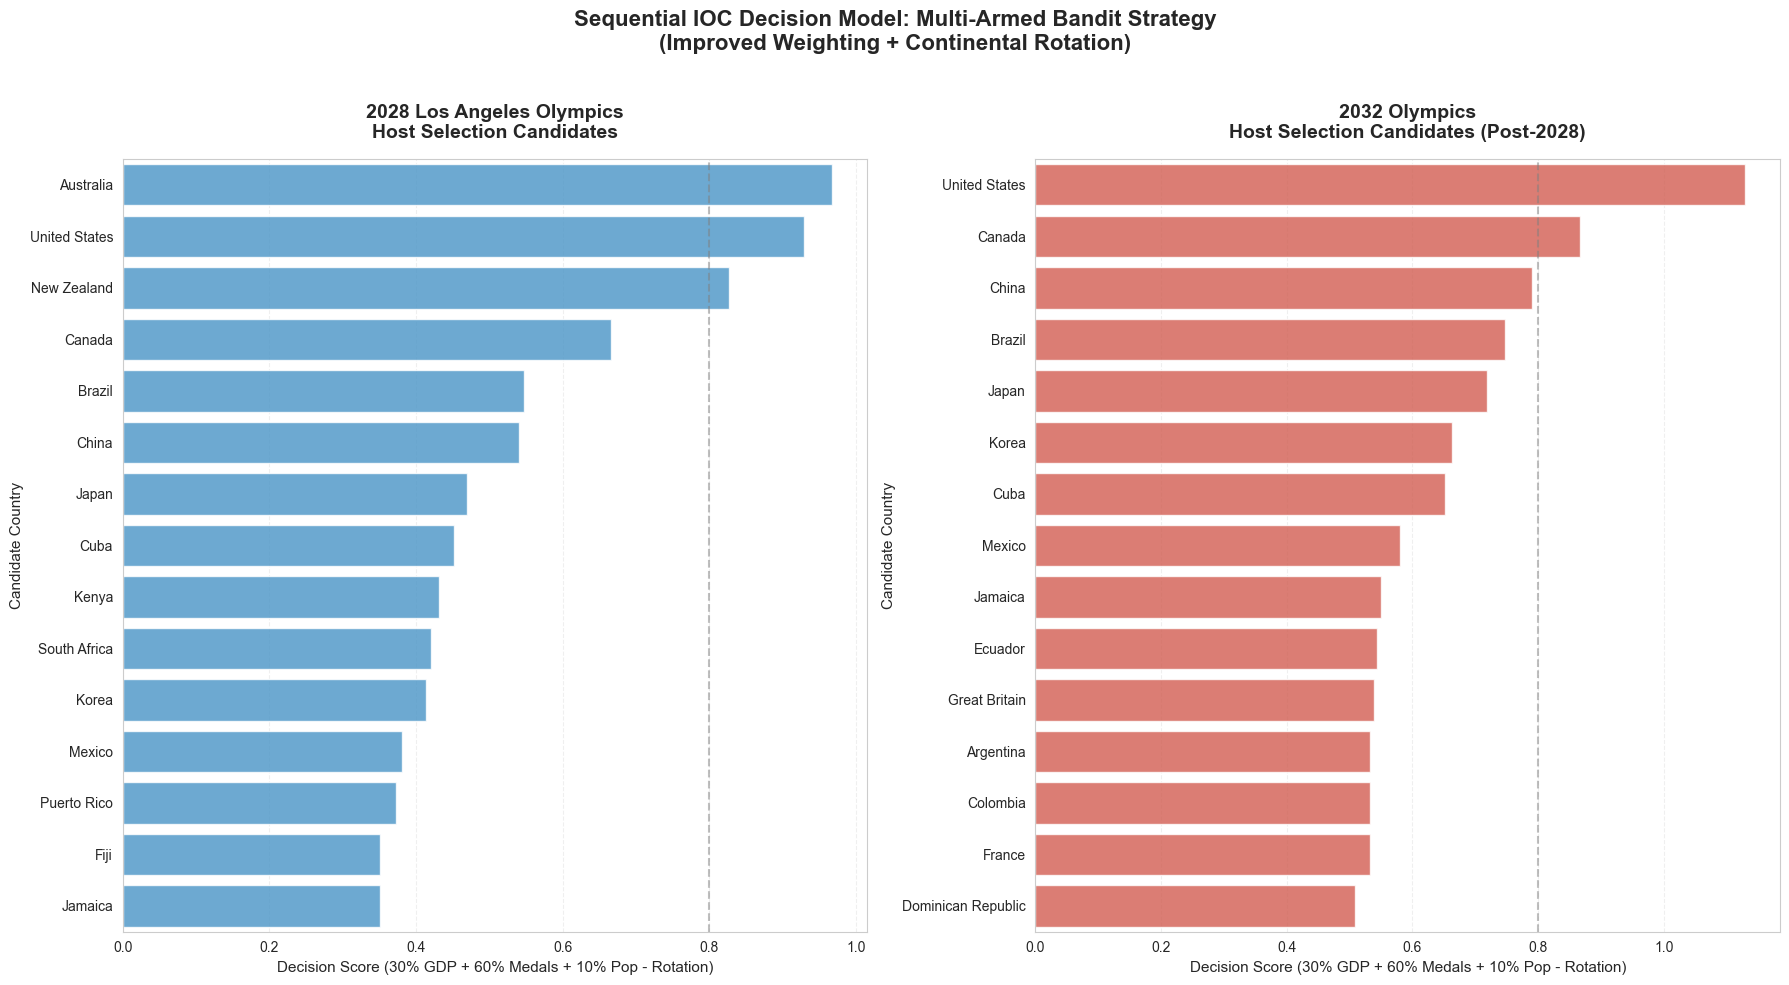


=== 2032 Perdiction ===
2032 Winner prediction: United States (Americas)
2032 Score: 1.129

Rotation effect: Oceania (2028) → Americas (2032)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. 数据准备 (Data Prep)
# ==========================================
# 加载您的数据
df_gdp = pd.read_csv('medals_population_gdp_2024_2004_processed.csv')
df_hosts = pd.read_csv('summerOly_hosts.csv')

# 简单的特征工程：计算总奖牌
df_gdp['Total_Medals_2024'] = df_gdp['Gold 2024'] + df_gdp['Silver 2024'] + df_gdp['Bronze 2024']

# --- 核心：建立大洲映射 (Continental Mapping) - 完善版（排除非洲） ---
# 这是轮换规则的基础
continent_map = {
    # 欧洲 (Europe) - 完整覆盖
    'United Kingdom': 'Europe', 'France': 'Europe', 'Germany': 'Europe',
    'Italy': 'Europe', 'Spain': 'Europe', 'Greece': 'Europe',
    'Netherlands': 'Europe', 'Belgium': 'Europe', 'Sweden': 'Europe',
    'Norway': 'Europe', 'Denmark': 'Europe', 'Finland': 'Europe',
    'Poland': 'Europe', 'Switzerland': 'Europe', 'Austria': 'Europe',
    'Czechia': 'Europe', 'Czech Republic': 'Europe', 'Hungary': 'Europe',
    'Romania': 'Europe', 'Croatia': 'Europe', 'Portugal': 'Europe',
    'Ireland': 'Europe', 'Serbia': 'Europe', 'Bulgaria': 'Europe',
    'Slovakia': 'Europe', 'Slovenia': 'Europe', 'Lithuania': 'Europe',
    'Estonia': 'Europe', 'Latvia': 'Europe', 'Ukraine': 'Europe',
    'Belarus': 'Europe', 'Georgia': 'Europe', 'Armenia': 'Europe',
    'Azerbaijan': 'Europe', 'Türkiye': 'Europe', 'Turkey': 'Europe',
    'Russia': 'Europe', 'Russian Federation': 'Europe', 'ROC': 'Europe',
    'Great Britain': 'Europe', 'Luxembourg': 'Europe', 'Cyprus': 'Europe',
    'Malta': 'Europe', 'Iceland': 'Europe', 'Moldova': 'Europe',
    'Albania': 'Europe', 'Bosnia and Herzegovina': 'Europe', 'Montenegro': 'Europe',
    'North Macedonia': 'Europe', 'Kosovo': 'Europe', 'San Marino': 'Europe',
    
    # 亚洲 (Asia) - 完整覆盖
    'China': 'Asia', "People's Republic of China": 'Asia',
    'Japan': 'Asia', 'South Korea': 'Asia', 'Korea': 'Asia',
    'India': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia',
    'IR Iran': 'Asia', 'Iran': 'Asia', 'Kazakhstan': 'Asia',
    'Chinese Taipei': 'Asia', 'Taiwan': 'Asia',
    'Hong Kong, China': 'Asia', 'Hong Kong': 'Asia',
    'Israel': 'Asia', 'Saudi Arabia': 'Asia', 'Qatar': 'Asia',
    'United Arab Emirates': 'Asia', 'UAE': 'Asia',
    'Singapore': 'Asia', 'Malaysia': 'Asia', 'Vietnam': 'Asia',
    'Philippines': 'Asia', 'Pakistan': 'Asia', 'Bangladesh': 'Asia',
    'Sri Lanka': 'Asia', 'Myanmar': 'Asia', 'Cambodia': 'Asia',
    'Laos': 'Asia', 'Mongolia': 'Asia', 'Uzbekistan': 'Asia',
    'Kyrgyzstan': 'Asia', 'Tajikistan': 'Asia', 'Turkmenistan': 'Asia',
    'Afghanistan': 'Asia', 'Nepal': 'Asia', 'Bhutan': 'Asia',
    'Jordan': 'Asia', 'Lebanon': 'Asia', 'Syria': 'Asia',
    'Iraq': 'Asia', 'Kuwait': 'Asia', 'Bahrain': 'Asia',
    'Oman': 'Asia', 'Yemen': 'Asia', 'Maldives': 'Asia',
    
    # 美洲 (Americas) - 完整覆盖
    'United States': 'Americas', 'USA': 'Americas', 'US': 'Americas',
    'Canada': 'Americas', 'Brazil': 'Americas', 'Mexico': 'Americas',
    'Argentina': 'Americas', 'Cuba': 'Americas', 'Colombia': 'Americas',
    'Chile': 'Americas', 'Peru': 'Americas', 'Jamaica': 'Americas',
    'Ecuador': 'Americas', 'Venezuela': 'Americas', 'Guatemala': 'Americas',
    'Dominican Republic': 'Americas', 'Costa Rica': 'Americas',
    'Panama': 'Americas', 'Uruguay': 'Americas', 'Bolivia': 'Americas',
    'Paraguay': 'Americas', 'El Salvador': 'Americas', 'Honduras': 'Americas',
    'Nicaragua': 'Americas', 'Trinidad and Tobago': 'Americas',
    'Bahamas': 'Americas', 'Barbados': 'Americas', 'Grenada': 'Americas',
    'Saint Lucia': 'Americas', 'Saint Kitts and Nevis': 'Americas',
    'Dominica': 'Americas', 'Antigua and Barbuda': 'Americas',
    'Saint Vincent and the Grenadines': 'Americas', 'Belize': 'Americas',
    'Guyana': 'Americas', 'Suriname': 'Americas', 'Haiti': 'Americas',
    
    # 大洋洲 (Oceania) - 完整覆盖
    'Australia': 'Oceania', 'New Zealand': 'Oceania',
    'Fiji': 'Oceania', 'Papua New Guinea': 'Oceania',
    'Samoa': 'Oceania', 'Tonga': 'Oceania', 'Vanuatu': 'Oceania',
    'Solomon Islands': 'Oceania', 'Kiribati': 'Oceania',
    'Micronesia': 'Oceania', 'Palau': 'Oceania', 'Marshall Islands': 'Oceania',
    'Nauru': 'Oceania', 'Tuvalu': 'Oceania', 'Cook Islands': 'Oceania',
    
    # 非洲国家不纳入轮换考量，映射到 Others
    # (如需要可以单独处理，但本次分析中将非洲排除在外)
}

# 处理国家名映射
host_mapping = {
    'United States': 'United States', 'Great Britain': 'United Kingdom', 
    'United Kingdom': 'United Kingdom', 'China': 'China', 'France': 'France', 
    'Japan': 'Japan', 'Germany': 'Germany', 'Australia': 'Australia',
    'Russia': 'Russia', 'South Korea': 'South Korea', 'Korea': 'South Korea', 
    'Brazil': 'Brazil', 'Spain': 'Spain', 'Greece': 'Greece',
    'Sweden': 'Sweden', 'Belgium': 'Belgium', 'Netherlands': 'Netherlands',
    'Finland': 'Finland', 'Italy': 'Italy', 'Mexico': 'Mexico',
    'Canada': 'Canada', 'New Zealand': 'New Zealand'
}

df_gdp['Mapped_Country'] = df_gdp['country'].map(host_mapping).fillna(df_gdp['country'])
df_gdp['Continent'] = df_gdp['Mapped_Country'].map(continent_map).fillna('Others')

# 标记是否举办过 (Has_Hosted)
def clean_host_country(s):
    if not isinstance(s, str): return ''
    for k, v in host_mapping.items():
        if k in s or v in s: return v
    return s.split(',')[-1].strip()

df_hosts['Clean_Host'] = df_hosts['Host'].apply(clean_host_country)
past_hosts = set(df_hosts['Clean_Host'].unique())
df_gdp['Has_Hosted'] = df_gdp['Mapped_Country'].apply(lambda x: 1 if x in past_hosts else 0)

# ==========================================
# 2. 计算硬实力 (Mu Capability) - 优化权重
# ==========================================
scaler = MinMaxScaler()
# 对数变换 + 归一化
for col in ['GDP 2024', 'Population 2024', 'Total_Medals_2024']:
    df_gdp[f'Norm_{col}'] = scaler.fit_transform(np.log1p(df_gdp[[col]]))

# 硬实力公式优化：30%经济 + 60%体育 + 10%人口
# 提高GDP权重，使经济实力强的国家（如美国）更有优势
df_gdp['Mu_Capability'] = (0.3 * df_gdp['Norm_GDP 2024'] + 
                           0.6 * df_gdp['Norm_Total_Medals_2024'] + 
                           0.1 * df_gdp['Norm_Population 2024'])

# ==========================================
# 3. 动态预测函数 (Sequential Prediction) - 优化惩罚
# ==========================================
def run_ioc_simulation(prev_history, df_input, year_label):
    df = df_input.copy()
    
    # 定义轮换惩罚 (Continental Rotation Penalty) - 优化版
    def get_penalty(cont):
        # Others（未分类/非洲）：不给惩罚，也不给奖励（中性处理）
        if cont == 'Others': 
            return 0.0
        
        # 刚办完 (Penalty 1.0 = 绝对排除)
        if len(prev_history) > 0 and cont == prev_history[0]: 
            return 1.0
        # 两届前 (Penalty 0.3 = 很难)
        if len(prev_history) > 1 and cont == prev_history[1]: 
            return 0.3
        # 三届前 (Penalty 0.05 = 轻微疲劳，已较远)
        if len(prev_history) > 2 and cont == prev_history[2]: 
            return 0.05
        
        # 长期未办的大洲给予较大奖励（鼓励多样性和公平轮换）
        # 澳大利亚2000年办过，但Oceania自那以后就没办过了
        if cont not in prev_history:
            return -0.15  # 负惩罚 = 15% 加成（大洲轮换红利）
        
        return 0.0

    df['Geo_Penalty'] = df['Continent'].apply(get_penalty)
    
    # 定义不确定性 (Sigma): 没办过的给高分
    df['Sigma'] = df['Has_Hosted'].apply(lambda x: 0.05 if x == 1 else 0.25)
    
    # 计算最终得分 (Score) - 保守策略 (探索权重=0.15)
    df['Score'] = df['Mu_Capability'] + (0.15 * df['Sigma']) - df['Geo_Penalty']
    
    # 整理结果
    df['Simulation_Year'] = year_label
    return df.sort_values('Score', ascending=False)

# ==========================================
# 4. 执行两轮预测
# ==========================================

# --- 第一轮: 2028 ---
# 历史背景: [2024欧洲, 2020亚洲, 2016美洲]
history_2028 = ['Europe', 'Asia', 'Americas']
results_2028 = run_ioc_simulation(history_2028, df_gdp, '2028 Prediction')
winner_2028 = results_2028.iloc[0] # 获取赢家

# --- 第二轮: 2032 ---
# 关键步骤：把 2028 的赢家的大洲加到历史列表的最前面！
# 新历史背景: [2028美洲, 2024欧洲, 2020亚洲]
history_2032 = [winner_2028['Continent'], 'Europe', 'Asia']
results_2032 = run_ioc_simulation(history_2032, df_gdp, '2032 Prediction')

# 输出统计信息
# print(f"\n=== 大洲映射统计 ===")
# print(df_gdp['Continent'].value_counts())
print(f"\n=== 2028 Perdiction ===")
print(f"\n2028 Winner prediction: {winner_2028['Mapped_Country']} ({winner_2028['Continent']})")
print(f"2028 Score: {winner_2028['Score']:.3f}")

# ==========================================
# 5. 绘图 (Visualization) - 分别显示 2028 和 2032
# ==========================================
top_n = 15
top_2028 = results_2028.head(top_n)
top_2032 = results_2032.head(top_n)

# 创建 1x2 子图布局
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
sns.set_style("whitegrid")

# === 左图: 2028 预测 ===
sns.barplot(
    data=top_2028, 
    x='Score', 
    y='country', 
    ax=ax1,
    color='#3498db',  # 蓝色
    alpha=0.8
)

ax1.set_title('2028 Los Angeles Olympics\nHost Selection Candidates', 
              fontsize=14, weight='bold', pad=15)
ax1.set_xlabel('Decision Score (30% GDP + 60% Medals + 10% Pop - Rotation)', fontsize=11)
ax1.set_ylabel('Candidate Country', fontsize=11)
ax1.axvline(x=0.8, color='grey', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.grid(axis='x', linestyle='--', alpha=0.3)


# === 右图: 2032 预测 ===
sns.barplot(
    data=top_2032, 
    x='Score', 
    y='country', 
    ax=ax2,
    color='#e74c3c',  # 红色
    alpha=0.8
)

ax2.set_title('2032 Olympics\nHost Selection Candidates (Post-2028)', 
              fontsize=14, weight='bold', pad=15)
ax2.set_xlabel('Decision Score (30% GDP + 60% Medals + 10% Pop - Rotation)', fontsize=11)
ax2.set_ylabel('Candidate Country', fontsize=11)
ax2.axvline(x=0.8, color='grey', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.grid(axis='x', linestyle='--', alpha=0.3)

# 总标题
fig.suptitle('Sequential IOC Decision Model: Multi-Armed Bandit Strategy\n(Improved Weighting + Continental Rotation)', 
             fontsize=16, weight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 输出对比信息
print(f"\n=== 2032 Perdiction ===")
winner_2032 = results_2032.iloc[0]
print(f"2032 Winner prediction: {winner_2032['Mapped_Country']} ({winner_2032['Continent']})")
print(f"2032 Score: {winner_2032['Score']:.3f}")
print(f"\nRotation effect: {winner_2028['Continent']} (2028) → {winner_2032['Continent']} (2032)")